In [125]:
import pandas as pd
import numpy as np
from datetime import datetime
import mysql.connector
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Kết nối database
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="crypto_db"
)
cursor = db_connection.cursor()

API_SERVER = "http://localhost:5000"

In [172]:
def send_to_api(endpoint, data):
    """Gửi dữ liệu tới API server."""
    try:
        url = f"{API_SERVER}/{endpoint}"
        response = requests.post(url, json=data)
        response.raise_for_status()
        print(f"Data sent to {endpoint} successfully: {response.json()}")
    except requests.RequestException as e:
        print(f"Failed to send data to {endpoint}: {e}")

def fetch_raw_data():
    """Lấy dữ liệu từ database."""
    query = "SELECT * FROM coin_data"
    df = pd.read_sql(query, db_connection)

    # Chuyển các cột kiểu object thành kiểu float
    numeric_columns = ['priceChange', 'priceChangePercent', 'weightedAvgPrice', 'lastPrice',
                    'openPrice', 'highPrice', 'lowPrice', 'volume', 'quoteVolume', 
                    'buyVolume', 'sellVolume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['time'] = pd.to_datetime(df['time'])
    # Xóa các cột 'openTime' và 'closeTime'
    df = df.drop(columns=['openTime', 'closeTime'])
    return df

def process_time_series_data(df, freq):
    """Xử lý dữ liệu theo thời gian."""
    df = df.set_index('time')  # Đặt 'time' làm index
    resampled = df.resample(freq).mean()  # Resample dữ liệu (ngày, tuần, tháng)
    return resampled.reset_index()

def calculate_correlation(df):
    """Tính toán ma trận tương quan."""
    correlation_matrix = df.corr()  # Tính toán ma trận tương quan
    return correlation_matrix

def seasonal_analysis(df):
    """Phân tích seasonal line của dữ liệu."""
    df.set_index('time', inplace=True)  # Đặt cột 'time' làm chỉ mục
    yearly_data = df.resample('Y').mean().reset_index()  # Resample theo năm và tính trung bình
    return yearly_data
    
def prepare_data(df):
    df['dayofyear'] = df['time'].dt.dayofyear  # Trích xuất ngày trong năm
    df['year'] = df['time'].dt.year  # Trích xuất năm
    df['month'] = df['time'].dt.month  # Trích xuất tháng
    df['day'] = df['time'].dt.day  # Trích xuất ngày
    df = df.set_index('time')  # Đặt cột 'time' làm chỉ mục
    return df

def predict_next_day_price(df,symbol):
    df = prepare_data(df)
    features = ['year', 'month', 'day', 'dayofyear', 'openPrice', 'highPrice', 'lowPrice', 'volume', 'quoteVolume']
    target = 'lastPrice'
    
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)
    print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')

    # Dự đoán cho ngày tiếp theo (ngày tiếp theo dựa trên ngày cuối cùng của dữ liệu)
    last_day = df.index[-1]
    next_day = last_day + pd.Timedelta(days=1)
    next_day_features = pd.DataFrame([[next_day.year, next_day.month, next_day.day, next_day.dayofyear,
                                       df.iloc[-1]['openPrice'], df.iloc[-1]['highPrice'], df.iloc[-1]['lowPrice'],
                                       df.iloc[-1]['volume'], df.iloc[-1]['quoteVolume']]],
                                     columns=features)

    next_day_prediction = model.predict(next_day_features)[0]
    print(f'Dự đoán giá trị {symbol} cho ngày {next_day.strftime("%Y-%m-%d")}: {next_day_prediction:.2f}')
    return next_day_prediction

In [129]:
raw_data = fetch_raw_data()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15312\583376901.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, db_connection)


In [131]:
print(raw_data.dtypes)

id                             int64
symbol                        object
priceChange                  float64
priceChangePercent           float64
weightedAvgPrice             float64
lastPrice                    float64
openPrice                    float64
highPrice                    float64
lowPrice                     float64
volume                       float64
quoteVolume                  float64
buyVolume                    float64
sellVolume                   float64
time                  datetime64[ns]
dtype: object


In [ ]:
raw_data = fetch_raw_data()

# Danh sách các đồng coin cần xử lý
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']

for symbol in symbols:
    # Lọc dữ liệu theo từng đồng coin
    df_symbol = raw_data[raw_data['symbol'] == symbol]
    # Xử lý dữ liệu theo ngày
    df_resample = df_symbol.drop(columns=['symbol','buyVolume','sellVolume','id'])
    daily_data = process_time_series_data(df_resample, 'D')
    weekly_data = process_time_series_data(df_resample, 'W')
    monthly_data = process_time_series_data(df_resample, 'ME')


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15312\583376901.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, db_connection)


Daily Data for BTCUSDT:
        time  priceChange  priceChangePercent  weightedAvgPrice  lastPrice  \
0 2019-12-02       -97.22           -1.315295           7391.50    7294.28   
1 2019-12-03        -1.71           -0.023443           7294.42    7292.71   
2 2019-12-04       -98.39           -1.349156           7292.71    7194.32   
3 2019-12-05       194.41            2.702169           7194.59    7389.00   
4 2019-12-06       138.47            1.874002           7389.00    7527.47   

   openPrice  highPrice  lowPrice        volume   quoteVolume  
0    7391.50    7420.56   7151.10  46330.256040  3.378893e+08  
1    7294.42    7400.00   7241.35  33149.477487  2.423793e+08  
2    7292.71    7750.00   7067.00  83153.701586  6.086706e+08  
3    7194.59    7485.00   7150.00  59306.678855  4.347389e+08  
4    7389.00    7590.03   7305.00  48189.087944  3.569059e+08  
Week Data for BTCUSDT:
        time  priceChange  priceChangePercent  weightedAvgPrice    lastPrice  \
0 2019-12-08    38.2

In [143]:
# Tạo một ma trận tương quan cho mỗi symbol
for symbol in symbols:
    # Lọc dữ liệu theo từng đồng coin
    df_symbol = raw_data[raw_data['symbol'] == symbol]
    df_symbol = df_symbol.drop(columns=['symbol', 'time', 'id']) 

    if not df_symbol.empty:
        correlation_matrix = calculate_correlation(df_symbol)
        print(correlation_matrix)
        
    else:
        print(f'No valid data for {symbol} to calculate correlation.')


                    priceChange  priceChangePercent  weightedAvgPrice  \
priceChange            1.000000            0.855717         -0.028445   
priceChangePercent     0.855717            1.000000         -0.042493   
weightedAvgPrice      -0.028445           -0.042493          1.000000   
lastPrice              0.024458            0.002919          0.998596   
openPrice             -0.028758           -0.042616          0.999995   
highPrice              0.000714           -0.017648          0.999243   
lowPrice               0.000756           -0.017269          0.998944   
volume                -0.010621            0.007622         -0.375834   
quoteVolume           -0.002220           -0.005212          0.103548   
buyVolume              0.001504           -0.000399         -0.000221   
sellVolume            -0.001504            0.000399          0.000215   

                    lastPrice  openPrice  highPrice  lowPrice    volume  \
priceChange          0.024458  -0.028758   0.000

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15312\1481492787.py:41: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.resample('Y').mean().reset_index()  # Resample theo năm và tính trung bình


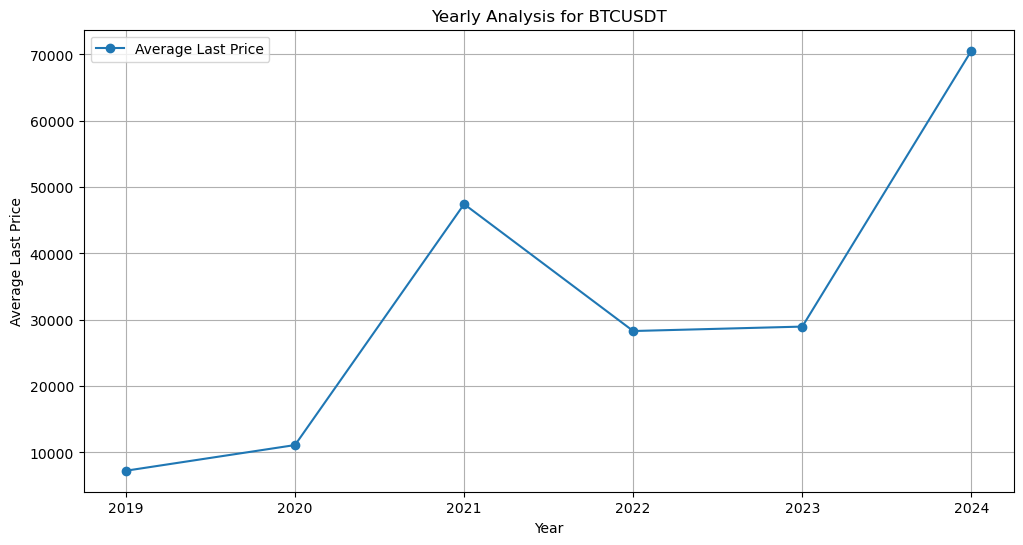

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15312\1481492787.py:41: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.resample('Y').mean().reset_index()  # Resample theo năm và tính trung bình


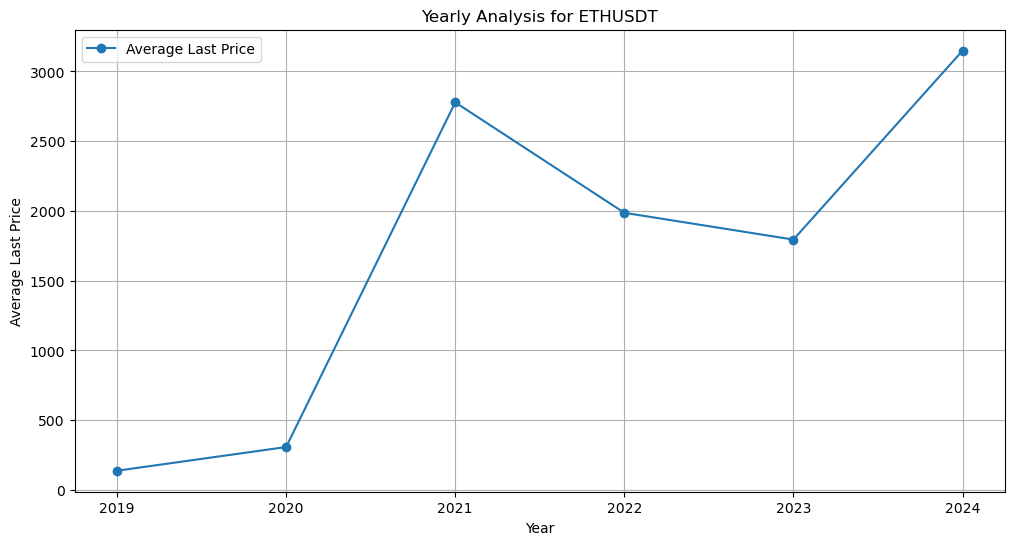

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15312\1481492787.py:41: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.resample('Y').mean().reset_index()  # Resample theo năm và tính trung bình


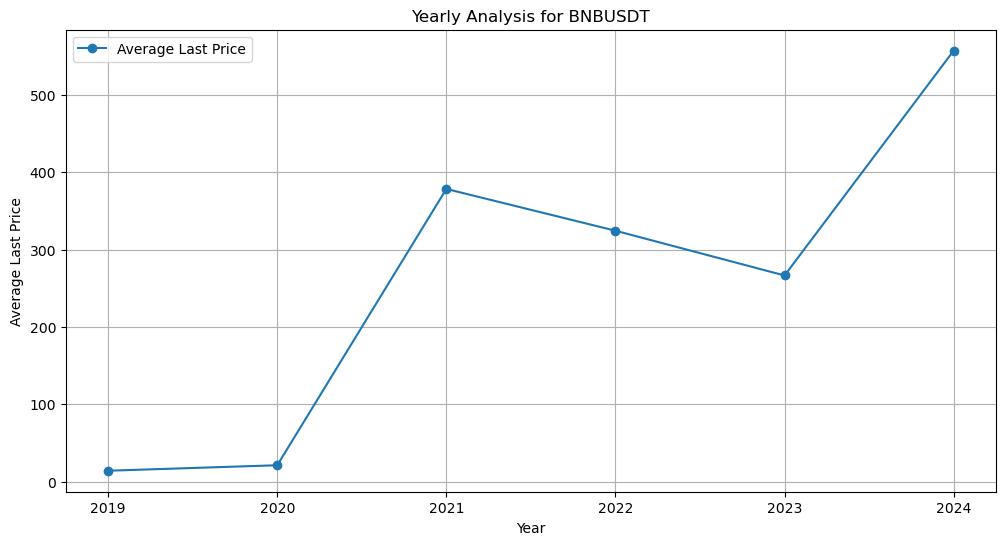

In [163]:
for symbol in symbols:
    # Lọc dữ liệu theo từng đồng coin
    df_symbol = raw_data[raw_data['symbol'] == symbol]
    df_symbol = df_symbol.drop(columns=['symbol', 'id']) 
    yearly_data = seasonal_analysis(df_symbol)
    
    # Vẽ biểu đồ line theo năm
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_data['time'].dt.year, yearly_data['lastPrice'], marker='o', linestyle='-', label='Average Last Price')
    plt.title(f'Yearly Analysis for {symbol}')
    plt.xlabel('Year')
    plt.ylabel('Average Last Price')
    plt.grid(True)
    plt.legend()
    plt.show()

In [173]:
for symbol in symbols:
    df_symbol = raw_data[raw_data['symbol'] == symbol].drop(columns=['symbol', 'id'])
    predicted_price = predict_next_day_price(df_symbol,symbol)


Mean Squared Error: 90278.45
Dự đoán giá trị BTCUSDT cho ngày 2024-12-02: 95985.78
Mean Squared Error: 286.50
Dự đoán giá trị ETHUSDT cho ngày 2024-12-02: 3681.76
Mean Squared Error: 9.26
Dự đoán giá trị BNBUSDT cho ngày 2024-12-02: 648.23
